In [44]:
import os
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
from osgeo import gdal, osr, ogr
from glob import glob
from shutil import copyfile

In [9]:
test_vector = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/test_line_labelling/test_line_labelling.shp"

line_shape = gpd.read_file(test_vector)

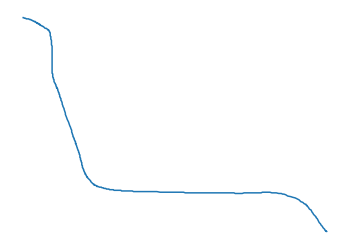

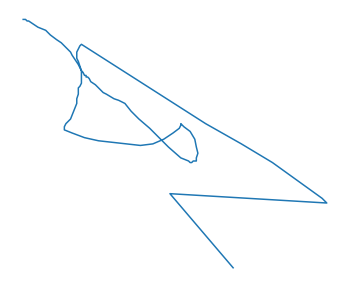

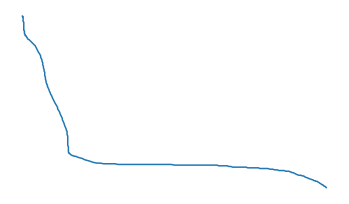

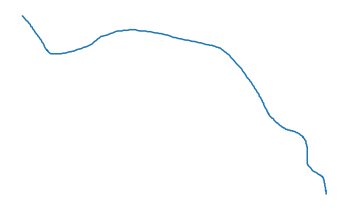

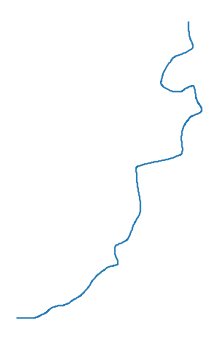

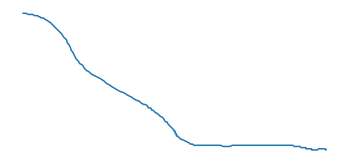

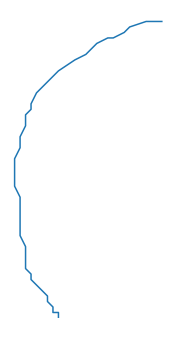

In [11]:
for index in range(line_shape.shape[0]):
    crop_extent = line_shape.loc[[index],"geometry"]
    
    # plot each extent
    fig, ax = plt.subplots(figsize = (6, 6))
    crop_extent.plot(ax=ax)
    ax.set_axis_off();

In [5]:
!pipenv graph

ipykernel==5.3.4
  - appnope [required: Any, installed: 0.1.0]
  - ipython [required: >=5.0.0, installed: 7.18.1]
    - appnope [required: Any, installed: 0.1.0]
    - backcall [required: Any, installed: 0.2.0]
    - decorator [required: Any, installed: 4.4.2]
    - jedi [required: >=0.10, installed: 0.17.2]
      - parso [required: >=0.7.0,<0.8.0, installed: 0.7.1]
    - pexpect [required: >4.3, installed: 4.8.0]
      - ptyprocess [required: >=0.5, installed: 0.6.0]
    - pickleshare [required: Any, installed: 0.7.5]
    - prompt-toolkit [required: >=2.0.0,<3.1.0,!=3.0.1,!=3.0.0, installed: 3.0.7]
      - wcwidth [required: Any, installed: 0.2.5]
    - pygments [required: Any, installed: 2.7.0]
    - setuptools [required: >=18.5, installed: 50.3.0]
    - traitlets [required: >=4.2, installed: 5.0.4]
      - ipython-genutils [required: Any, installed: 0.2.0]
  - jupyter-client [required: Any, installed: 6.1.7]
    - jupyter-core [required: >=4.6.0, installed: 4.6.3]
      - traitlets 

# Functional Intersection Code

In [72]:
raster_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2_Misha/Polygon_Crops/MSK/Chips/26/full_list/"
raster_list = glob(raster_path + "/*")
vector_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/test_line_labelling/test_line_labelling.shp"
output_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2_Misha/Polygon_Crops/MSK/Chips/26/yes/"


vector = ogr.Open(vector_path)

# Get vector geometry
layer = vector.GetLayer()
feature_count = vector.GetLayer().GetFeatureCount()

for feature_number in range(feature_count):
    feature = layer.GetFeature(feature_number)
    vectorGeometry = feature.GetGeometryRef()

    for raster_path in raster_list:
        raster = gdal.Open(raster_path)

        # Get raster geometry
        transform = raster.GetGeoTransform()
        pixelWidth = transform[1]
        pixelHeight = transform[5]
        cols = raster.RasterXSize
        rows = raster.RasterYSize

        xLeft = transform[0]
        yTop = transform[3]
        xRight = xLeft+cols*pixelWidth
        yBottom = yTop+rows*pixelHeight

        ring = ogr.Geometry(ogr.wkbLinearRing)
        ring.AddPoint(xLeft, yTop)
        ring.AddPoint(xLeft, yBottom)
        ring.AddPoint(xRight, yBottom)
        ring.AddPoint(xRight, yTop)
        ring.AddPoint(xLeft, yTop)
        rasterGeometry = ogr.Geometry(ogr.wkbPolygon)
        rasterGeometry.AddGeometry(ring)
        
        # If intersection detected, copy chip to destination directory
        if rasterGeometry.Intersect(vectorGeometry):
            out_file = output_path + raster_path.split("/")[-1]
            copyfile(raster_path,out_file)
            raster_list.remove(raster_path)